# Run quadratic parameterisation


Parameterisation example is quadratic local with mean Antarctic slope (= no slope dependency) as defined in Burgard et al. (2022).
Based on code created by Clara Burgard. Please note that we create the melt rates here, whereas in MeltMIP/ISMIP7 we ask modellers to use their parameterisation implemented in the ice sheet model to produce melt rates for parameter selection.

In [1]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

#import multimelt.melt_functions as meltf
from multimelt.constants import *

from parameter_selection_toolbox import *

# Settings

In [2]:
# Directories
figure_dir = 'figures'
data_path="/media/NAS2/ISMIP7/share_with_modellers"
ensemble_path="/mnt/FastStore1/quadratic_out"


# Constants
yearlen = 365.14*24*60*60 # seconds per year
ice_density = 918 # kg/m3
reso=8000 # m model resolution used for melt parameterisation [m]

# parameterisation ensemble table 
p1_name = 'K'
p2_name = 'dummy'

quadratic_present_day_ensemble = "ensemble_quadratic"


# Modellers provided data

In [3]:
# Load climatology
climatology = xr.load_dataset(os.path.join(data_path, "climatology", "zhou_annual_30_sep", "OI_Climatology_ismip8km_60m_tf_extrap.nc"))
salinity = xr.load_dataset(os.path.join(data_path, "climatology", "zhou_annual_30_sep","OI_Climatology_ismip8km_60m_so_extrap.nc"))

# Load BedMap3
bed = xr.load_dataset(os.path.join(data_path, "topography", "bedmap3_ismip_8km.nc"))

# get thermal forcing at the ice shelf draft
tf_draft = climatology.tf.sel(z=bed['draft'], method='nearest')
tf_draft = tf_draft.where(tf_draft>0, 0) # remove negative values
tf_draft = tf_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

so_draft = salinity.so.sel(z=bed['draft'], method='nearest')
so_draft = so_draft.where(so_draft>0, 0) # remove negative values
S0 = so_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

U_factor = (c_po / L_i) * beta_coeff_lazero * (g/(2*abs(f_coriolis))) * S0

In [4]:
ensemble_table = pd.read_csv('./'+quadratic_present_day_ensemble+'.txt',
                                 sep=r'\s+',index_col=0)

In [5]:
# Load ensembles

quadratic_present_day_ensemble = "pd_zhou"
quadratic_mathiot_cold_ensemble = "Mathiot23_cold"
quadratic_mathiot_warm_ensemble = "Mathiot23_warm"

pd_ensemble = xr.load_dataset('Ensemble_'+quadratic_present_day_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_cold_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_cold_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_warm_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_warm_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])

In [6]:
pd_ensemble.p1

<xarray.DataArray 'p1' (p1: 96)> Size: 768B
array([5.0e-06, 6.0e-06, 7.0e-06, 8.0e-06, 9.0e-06, 1.0e-05, 1.1e-05, 1.2e-05,
       1.3e-05, 1.4e-05, 1.5e-05, 1.6e-05, 1.7e-05, 1.8e-05, 1.9e-05, 2.0e-05,
       2.1e-05, 2.2e-05, 2.3e-05, 2.4e-05, 2.5e-05, 2.6e-05, 2.7e-05, 2.8e-05,
       2.9e-05, 3.0e-05, 3.1e-05, 3.2e-05, 3.3e-05, 3.4e-05, 3.5e-05, 3.6e-05,
       3.7e-05, 3.8e-05, 3.9e-05, 4.0e-05, 4.1e-05, 4.2e-05, 4.3e-05, 4.4e-05,
       4.5e-05, 4.6e-05, 4.7e-05, 4.8e-05, 4.9e-05, 5.0e-05, 5.1e-05, 5.2e-05,
       5.3e-05, 5.4e-05, 5.5e-05, 5.6e-05, 5.7e-05, 5.8e-05, 5.9e-05, 6.0e-05,
       6.1e-05, 6.2e-05, 6.3e-05, 6.4e-05, 6.5e-05, 6.6e-05, 6.7e-05, 6.8e-05,
       6.9e-05, 7.0e-05, 7.1e-05, 7.2e-05, 7.3e-05, 7.4e-05, 7.5e-05, 7.6e-05,
       7.7e-05, 7.8e-05, 7.9e-05, 8.0e-05, 8.1e-05, 8.2e-05, 8.3e-05, 8.4e-05,
       8.5e-05, 8.6e-05, 8.7e-05, 8.8e-05, 8.9e-05, 9.0e-05, 9.1e-05, 9.2e-05,
       9.3e-05, 9.4e-05, 9.5e-05, 9.6e-05, 9.7e-05, 9.8e-05, 9.9e-05, 1.0e-04])
Coordinates:
  * p1       (p1) float64 768B 5e-06 6e-06 7e-06 ... 9.8e-05 9.9e-05 0.0001

# Load data

In [7]:
# Supporting Data

# Load imbie2 basins as used on ISMIP
basins = xr.load_dataset(os.path.join(data_path, 'imbie2', "basin_numbers_ismip8km.nc"))
basins = basins.rename({'basinNumber':'basins'}) # basins now start at 0

nBasins = int(basins.basins.max())

# present-day melting, melt rates from Paolo et al., 2023, error estimates combined from Paolo and Adusumilli et al., 2020
melt_obs = xr.load_dataset(os.path.join(data_path, 'meltmip','melt_paolo_err_adusumilli_ismip8km.nc')) # Field
MeltDataImbie = pd.read_csv(os.path.join(data_path, 'meltmip','Melt_Paolo_Err_Adusumilli_imbie2.csv'), index_col=0) # Aggregated per imbier basin

# Buttressing Flux Response Numbers, remapped to 8km 
bfrn = xr.load_dataset(os.path.join(data_path, 'meltmip',"BFRN_ismip8km.nc"))
nBins = 10

In [8]:
# Load BedMap3
bed = xr.load_dataset(os.path.join(data_path, "topography", "bedmap3_ismip_8km.nc"))

mask = bed.floating_frac>0.5

# Sample

In [9]:
#condition = pd_ensemble.p1 <= 1e-4

#pd_ensemble = pd_ensemble.where(condition, drop=True)
#mathiot_cold_ensemble = mathiot_cold_ensemble.where(condition, drop=True)
#mathiot_warm_ensemble = mathiot_warm_ensemble.where(condition, drop=True)

In [11]:
sample_size=1000#0
w3_spec='none' # 'None'
min_p1, min_p2, a1,a2,a3, t3_weights = calculate_objective_function('all', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble,w3_spec)

Sampling, this might take a moment...


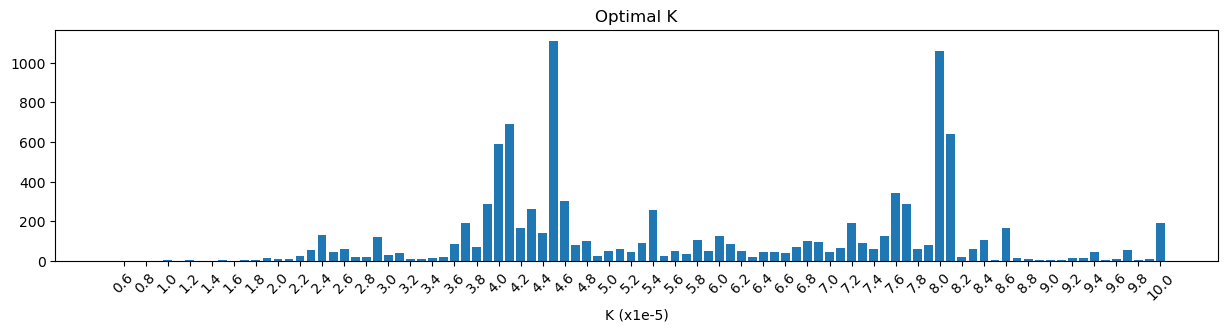

In [19]:
fig,axes = plt.subplots(1,1, sharex=False, sharey=False, figsize=(15,3))
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(pd_ensemble.p1.values[0]-0.01e-5, pd_ensemble.p1.values+0.01e-5) )
#bin_edges = 0.5*np.array([1e-6,5e-6,1e-5,1e-4, 2.5e-4, 5e-4, 7.5e-4,1e-3, 2e-3 ] )
counts, _ = np.histogram(np.array(min_p1), bins= bin_edges)
positions = np.arange(len(pd_ensemble.p1.values))
ax.bar(positions, counts, width=0.8)
labels = np.round(pd_ensemble.p1.values*1e5, 1)
#labels = pd_ensemble.p1.values#*1e5, 2)
#ax.set_xticks(positions, labels, rotation=45)
ax.set_xticks(positions[1::2], labels[1::2], rotation=45)
ax.set_xlabel('K (x1e-5)')
ax.set_title('Optimal K')

#ax.set_xlim([pd_ensemble.p1.values[0]*1e5, pd_ensemble.p1.values[-1]*1e5])

plt.savefig(os.path.join(figure_dir,'quadratic_present_day_Hist_Sample'+str(sample_size)+'_.png'))  

In [105]:
counts

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    3,  342,  234, 2019,   31,   71,
          0,    0,  701,    0,    8,    0,    0,    0,    0,   32, 1148,
         71,  797, 1414, 1976,  130,  299,   64,  380,  238,    3,    0,
          0,    7,    0,    1,    0,   15,   11,    1,    0,    0,    0,
          0,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [106]:
# Find min, max, 5th, 95th, and modes

print('min = ', np.min(np.array(min_p1)))
print('1st = ', np.percentile(np.array(min_p1), 1))
print('5th = ', np.percentile(np.array(min_p1), 5))
print('median = ', np.median(np.array(min_p1)))
print('95th = ', np.percentile(np.array(min_p1), 95))
print('99th = ', np.percentile(np.array(min_p1), 99))
print('max = ', np.max(np.array(min_p1)))

# Find local maxima for modes, 
peaks, _ = find_peaks(counts)
modes = pd_ensemble.p1.values[peaks]
print('Modes = ', modes)

min =  2.0999999999999995e-05
1st =  2.2e-05
5th =  2.3e-05
median =  3.899999999999999e-05
95th =  4.499999999999999e-05
99th =  4.599999999999999e-05
max =  8.099999999999998e-05
Modes =  [2.2e-05 2.4e-05 2.6e-05 2.9e-05 3.1e-05 3.7e-05 4.1e-05 4.3e-05 4.5e-05
 5.0e-05 5.2e-05 5.4e-05 6.1e-05 8.1e-05]


In [82]:
# Find min, max, 5th, 95th, and modes

print('min = ', np.min(np.array(min_p1)))
print('1st = ', np.percentile(np.array(min_p1), 1))
print('5th = ', np.percentile(np.array(min_p1), 5))
print('median = ', np.median(np.array(min_p1)))
print('95th = ', np.percentile(np.array(min_p1), 95))
print('99th = ', np.percentile(np.array(min_p1), 99))
print('max = ', np.max(np.array(min_p1)))

# Find local maxima for modes, 
peaks, _ = find_peaks(counts)
modes = pd_ensemble.p1.values[peaks]
print('Modes = ', modes)

min =  2.5e-05
1st =  2.5e-05
5th =  2.5e-05
median =  4e-05
95th =  4.5e-05
99th =  4.5e-05
max =  9e-05
Modes =  [2.5e-05 4.0e-05 8.0e-05]


[2.5e-05 4.0e-05 8.0e-05]


In [54]:
# Analyse the tail of the distribution, which cases generate this?
Kt = 1.1e-3#55.5*1e-5
print("Testing K=", Kt)
indices = [i for i, x in enumerate(min_p1) if x == Kt]
print(indices) 
#print(indices[0])

print("a1=",a1[indices]/np.median(a1))
print("a2=",a2[indices]/np.median(a2))
print("a3=",a3[indices]/np.median(a3))
print("w3=",t3_weights[indices])


Testing K= 0.0011
[493, 613, 872, 2378, 3687, 3817, 5178, 5902, 6430, 6799, 7499, 8166, 8960, 9110, 9692]
a1= [2.1117658  0.88367445 1.33245219 1.88589519 1.43369704 1.24795076
 1.28711363 0.66800412 1.36678408 0.65063429 0.25911919 1.40651335
 1.79185845 1.43327602 0.88584652]
a2= [0.86997204 2.01991368 1.29033891 1.09219988 1.37069183 1.55960121
 1.68618428 2.09885636 1.35308169 2.02100149 2.51548598 1.41176786
 0.96911833 1.3817506  1.86226898]
a3= [0.00963249 0.07300575 0.36558775 0.01033609 0.18159288 0.17588561
 0.00724123 0.2096773  0.26696759 0.30663568 0.19631599 0.16705101
 0.23068086 0.17072993 0.23171641]
w3= [[1.59103991e-02 3.11698105e-02 3.17676679e-02 4.75346505e-03
  4.88425176e-02 6.56599765e-03 3.44129708e-02 6.04522274e-02
  5.63929420e-02 4.46273834e-02 4.57916353e-02 4.27301823e-03
  3.10335488e-02 5.82440667e-03 4.15858302e-02 3.65961793e-02
  1.59103991e-02 3.11698105e-02 3.17676679e-02 4.75346505e-03
  4.88425176e-02 6.56599765e-03 3.44129708e-02 6.04522274e-02

In [45]:
#p#d_ensemble.sel(p1=Kt).melt_rate.plot(vmin=-1, vmax=80, figsize=(15,10))

In [43]:
# Look into min, max, modes




In [46]:
#print('min = ', np.min(np.array(min_p1)))
print('1st = ', np.percentile(np.array(min_p1), 1))
print('5th = ', np.percentile(np.array(min_p1), 5))
print('median = ', np.median(np.array(min_p1)))
print('95th = ', np.percentile(np.array(min_p1), 95))
print('99th = ', np.percentile(np.array(min_p1), 99))
#print('max = ', np.max(np.array(min_p1)))

# To incorporate a wider range of uncertainty, it might make sense to use 1st and 99th percentiles.

1st =  1.5000000000000002e-05
5th =  3e-05
median =  0.000315
95th =  0.00101
99th =  0.0011


# Analyse sensitivity

In [47]:
Kt= 55.5e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 6.91 m/a/K
Basin  2 : 7.81 m/a/K
Basin  3 : 9.21 m/a/K
Basin  4 : 12.25 m/a/K
Basin  5 : 19.31 m/a/K
Basin  6 : 8.56 m/a/K
Basin  7 : 8.81 m/a/K
Basin  8 : 7.97 m/a/K
Basin  9 : 11.65 m/a/K
Basin  10 : 21.86 m/a/K
Basin  11 : 9.38 m/a/K
Basin  12 : 13.18 m/a/K
Basin  13 : 11.84 m/a/K
Basin  14 : 8.05 m/a/K
Basin  15 : 8.17 m/a/K
Basin  16 : 8.03 m/a/K
Corresponding deltaT values: [-0.7  -0.65 -0.35 -0.05 -1.5  -0.65 -0.85 -0.4  -0.65 -0.45 -0.65 -1.3
 -0.05 -0.55 -0.3  -0.3 ]


In [18]:
Kt= 3.5e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 1.14 m/a/K
Basin  2 : 1.07 m/a/K
Basin  3 : 1.35 m/a/K
Basin  4 : 1.83 m/a/K
Basin  5 : 3.45 m/a/K
Basin  6 : 2.44 m/a/K
Basin  7 : 1.52 m/a/K
Basin  8 : 0.88 m/a/K
Basin  9 : 2.91 m/a/K
Basin  10 : 3.73 m/a/K
Basin  11 : 2.34 m/a/K
Basin  12 : 2.49 m/a/K
Basin  13 : 1.62 m/a/K
Basin  14 : 1.36 m/a/K
Basin  15 : 0.71 m/a/K
Basin  16 : 1.22 m/a/K
Corresponding deltaT values: [ 0.15  0.    0.45  1.05  1.3   1.4   0.35  0.    1.65  2.    1.25  0.55
  0.85  0.4  -0.1   0.45]


In [19]:
Kt= 10e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 1.91 m/a/K
Basin  2 : 2.11 m/a/K
Basin  3 : 2.75 m/a/K
Basin  4 : 3.58 m/a/K
Basin  5 : 5.59 m/a/K
Basin  6 : 4.36 m/a/K
Basin  7 : 2.31 m/a/K
Basin  8 : 1.97 m/a/K
Basin  9 : 5.32 m/a/K
Basin  10 : 9.69 m/a/K
Basin  11 : 4.21 m/a/K
Basin  12 : 4.38 m/a/K
Basin  13 : 3.24 m/a/K
Basin  14 : 2.5 m/a/K
Basin  15 : 1.74 m/a/K
Basin  16 : 2.51 m/a/K
Corresponding deltaT values: [-0.35 -0.35  0.05  0.45 -0.25  0.45 -0.4  -0.2   0.55  1.65  0.35 -0.45
  0.35 -0.1  -0.2   0.1 ]


In [20]:
Kt= 50e-05

for basin in range(1,17): # Note that these are the PICO basins which are different from the IMBIE ones
    print('Basin ', basin, ':',np.round(pd_ensemble['sensitivity_per_basin'].sel(p1=Kt,p2=1,basin=basin, method='nearest').values,2), 'm/a/K')

print('Corresponding deltaT values:', pd_ensemble['optimal_deltaT_per_basin'].sel(p1=Kt,p2=1, method='nearest').values)


Basin  1 : 6.23 m/a/K
Basin  2 : 7.04 m/a/K
Basin  3 : 8.29 m/a/K
Basin  4 : 11.04 m/a/K
Basin  5 : 17.52 m/a/K
Basin  6 : 7.71 m/a/K
Basin  7 : 7.94 m/a/K
Basin  8 : 7.18 m/a/K
Basin  9 : 11.67 m/a/K
Basin  10 : 21.02 m/a/K
Basin  11 : 8.88 m/a/K
Basin  12 : 11.87 m/a/K
Basin  13 : 11.36 m/a/K
Basin  14 : 7.69 m/a/K
Basin  15 : 7.36 m/a/K
Basin  16 : 7.24 m/a/K
Corresponding deltaT values: [-0.7  -0.65 -0.35 -0.05 -1.45 -0.65 -0.85 -0.4  -0.55 -0.35 -0.6  -1.3
  0.   -0.5  -0.3  -0.3 ]
